# Его величество, "домашка №1"

В этой домашней работе вам предоставится уникальная возможность обучить Byte-level BPE токенизатор и небольшую LM.  

Домашняя работа состоит из нескольких последовательных блоков: реализация и обучение токенизатора, реализация Transformer модели и обучение модели на датасете с русскими анекдотами!

Обученные токенизатор и модель можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). Зарегистрируйтесь там, подпишитесь на [deep vk](https://huggingface.co/deepvk) и создайте себе API токен.

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

In [ ]:
# Установим необходимые дополнительные библиотеки

#%pip install --quiet datasets livelossplot

In [ ]:
# Необходимые импорты

import inspect
import json
import os
from collections import Counter
from dataclasses import dataclass
from functools import lru_cache, partial
from pathlib import Path

import regex as re
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, PyTorchModelHubMixin, interpreter_login, snapshot_download
from huggingface_hub.utils import SoftTemporaryDirectory
from livelossplot import PlotLosses
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

In [ ]:
# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)


def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")

In [ ]:
interpreter_login()

In [ ]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw1"  # Или как вам хочется

print(f"Homework repository: '{REPO_NAME}'")

# И другие полезные вещи
SEED = 0xC0FFEE

# Датасет

Первым делом загрузим данные: [🤗 IgorVolochay/russian_jokes](https://huggingface.co/datasets/IgorVolochay/russian_jokes)

И немного посмотрим на них 👀

In [ ]:
import os
from datasets import load_dataset, load_from_disk

dataset_dir = "data"

if os.path.exists(dataset_dir):
    dataset = load_from_disk(dataset_dir)
else:
    dataset = load_dataset("IgorVolochay/russian_jokes", data_files="dataset.csv")
    dataset.save_to_disk(dataset_dir)

In [ ]:
#dataset = load_dataset("IgorVolochay/russian_jokes", data_files='dataset.csv')
#print("\n===\n".join(dataset["train"]["text"][:3]))

In [ ]:
# Подготовим холдауты
dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
dataset

# Токенизатор [6 баллов]

В качестве токенизатора будем использоват Byte-level BPE.

Для этого:
1. Реализуем его обучения, нам необходимо построить словарь заданного размера и набор слияний по этому словарю
2. Обучим токенизатор на датасете
3. Реализуем инференс токенизатора: кодирование текста и декодирование токенов


In [ ]:
# Всякие полезности

WHITESPACE_SPLITTER = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")


def bytes_to_unicode() -> dict[int, str]:
    """The original dictionary consists of 256 bytes and their corresponding Unicode characters.
    For example, chr(33) is '!'. However, not all bytes have a visually appealing representation,
    so such characters are skipped and replaced with the first available ones, i.e. shifted by 256.
    """
    initial_bytes = (
        list(range(ord("!"), ord("~") + 1)) +
        list(range(ord("¡"), ord("¬") + 1)) +
        list(range(ord("®"), ord("ÿ") + 1)) +
        list(range(ord("А"), ord("Я") + 1)) +
        list(range(ord("а"), ord("я") + 1))
    )
    initial_chars = [chr(it) for it in initial_bytes]
    n = 0
    for byte in range(2**8):
        if byte not in initial_bytes:
            initial_bytes.append(byte)
            initial_chars.append(chr(2**8 + n))
            n += 1
    return dict(sorted(zip(initial_bytes, initial_chars)))

In [ ]:
d = bytes_to_unicode()
print(d.values())

In [ ]:
def merge(merge_pair: tuple[str, str], pair_frequences: Counter[tuple[str, str]], words_by_tokens: Counter[tuple[str]]):
    """Merges a given pair of tokens and update corresponding stats

    Args:
        merge_pair: The pair of tokens to be merged.
        pair_frequences: A counter tracking the frequency of token pairs in the dataset.
        words_by_tokens: A counter mapping tokenized words to their frequencies.

    Returns:
        Updated pair frequences and word tokenization w.r.t. to new token.
    """
    new_words_by_tokens = Counter()

    for word, freq in words_by_tokens.items():
        new_word = []
        i = 0
        while i < len(word):
            if i < len(word) - 1 and (word[i], word[i + 1]) == merge_pair:
                new_word.append(word[i] + word[i + 1])
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_words_by_tokens[tuple(new_word)] += freq

    new_pair_frequences = Counter()
    for tokens, freq in new_words_by_tokens.items():
        for i in range(len(tokens) - 1):
            new_pair_frequences[(tokens[i], tokens[i+1])] += freq

    return new_pair_frequences, new_words_by_tokens


def train(data: list[str], vocab_size: int = 1024, special_tokens: list[str] = None):
    """Train BPE tokenizer on passed data

    Args:
        data: List of train documents
        vocab_size: Size of target vocabulary
        special_tokens: List of special tokens to add into vocabulary
    Returns:
        vocabulary: mapping from string token to id
        merges: list of merges, each one is tuple of string tokens
    """
    if vocab_size < 256:
        raise ValueError("Vocab size can't be less than 256")
    if special_tokens is None:
        special_tokens = []

    # 1. Initialize vocabulary (using inverse one during training)
    id2token = bytes_to_unicode()
    merges = []

    # 2. Load data
    words_by_tokens = Counter()
    for sample in tqdm(data, desc="Loading data"):
        # 2.1 Split into words
        words = WHITESPACE_SPLITTER.findall(sample.strip())
        for word in words:
            # 2.2 Tokenize with base vocabulary
            tokens = tuple(id2token[b] for b in word.encode('utf-8'))
            words_by_tokens[tokens] += 1

    # 3. Calculate statistic of token's pairs
    pair_frequences = Counter()
    for tokens, freq in words_by_tokens.items():
        for i in range(len(tokens) - 1):
            pair_frequences[(tokens[i], tokens[i+1])] += freq

    # 4. Build vocabulary
    pbar = trange(vocab_size, desc="Building vocabulary", initial=len(id2token) + len(special_tokens))
    while len(id2token) < vocab_size - len(special_tokens):
        if len(pair_frequences) == 0:
            print("Not enough data to fulfil vocabulary")
            break

        # 4.1 Find the most frequent pair and create new token
        top_pair = max(pair_frequences, key=pair_frequences.get)
        new_token = top_pair[0] + top_pair[1]
        del pair_frequences[top_pair]

        # 4.2 Add to vocabulary
        if new_token in id2token.values():
            continue
        id2token[len(id2token)] = new_token
        merges.append(top_pair)

        # 4.3 Update stats and merge the top pair in all tokens
        pair_frequences, words_by_tokens = merge(top_pair, pair_frequences, words_by_tokens)

        pbar.update()
    pbar.close()

    # 5. Add special tokens
    for special_token in special_tokens:
        id2token[len(id2token)] = special_token

    return {v: k for k, v in id2token.items()}, merges

In [ ]:
# Обучаем токенизатор на тренировочных текстах
# Для нашей задачи хватит и небольшого словаря, но можете пробовать и большего размера обучить!


vocab, merges = train(dataset["train"]["text"], vocab_size=1024, special_tokens=["[EOS]"])

In [ ]:
# Посмотрим на случайные токены

random_tokens = [512, 614, 768, 888, 1022]
unicode_to_bytes = {v: k for k, v in bytes_to_unicode().items()}
for token_id in random_tokens:
    token = [k for k, v in vocab.items() if v == token_id][0]
    raw_bytes = bytes([unicode_to_bytes[it] for it in token])
    print(f"Token #{token_id}: '{raw_bytes.decode('utf-8', errors='replace')}'")

In [ ]:
class ByteLevelBPETokenizer:

    def __init__(self, vocab: dict[str, int], merges: list[tuple[str, str]], eos_token: str = "[EOS]"):
        """Byte-Level BPE Tokenizer

        Args:
            vocab: mapping from string token to id
            merges: list of merges in prioritized order
            eos_token: string representation of EOS token
        """
        super().__init__()
        if eos_token not in vocab:
            raise ValueError("There is no EOS token in vocab")
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        self.token2id = vocab
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.eos_token = eos_token
        self.eos_token_id = self.token2id[eos_token]

        # The closer the pair is to the beginning, the higher the rank
        self.merges = merges
        self.bpe_ranks = {pair: i for i, pair in enumerate(merges)}

    def get_pairs(self, word: tuple[str]) -> set[tuple[str, str]]:
        pairs = set()
        for i in range(len(word) - 1):
            pairs.add((word[i], word[i+1]))
        return pairs


    @lru_cache
    def bpe(self, word: tuple[str]) -> tuple[str]:
        """Process word into tokenized representation.
        Word is a tuple of base tokens, i.e. bytes.

        Under the hood:
        1. Tracks the set of token pairs, bi-grams
        2. While possible, replaces the highest-ranking pair with its union

        Args:
            word: list of base string tokens
        Return:
            list of BPE tokens
        """
        if len(word) == 1:
            return word

        word = list(word)
        pairs = self.get_pairs(tuple(word))

        while True:
            candidate = None
            min_rank = float('inf')
            for pair in pairs:
                if pair in self.bpe_ranks and self.bpe_ranks[pair] < min_rank:
                    min_rank = self.bpe_ranks[pair]
                    candidate = pair

            if candidate is None:
                break

            first, second = candidate
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                except ValueError:
                    new_word.extend(word[i:])
                    break

                new_word.extend(word[i:j])
                if j < len(word) - 1 and word[j] == first and word[j+1] == second:
                    new_word.append(first + second)
                    i = j + 2
                else:
                    new_word.append(word[j])
                    i = j + 1

            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = self.get_pairs(tuple(word))
        return tuple(word)

    def encode(self, text: str, add_eos_token: bool = True) -> list[int]:
        """Convert string to list of token ids.

        Args:
            text: input string, may contain multiple words
            add_eos_token: whether to add eos token id at the end
        Return:
            list of ints, ids of tokenized text
        """
        words = WHITESPACE_SPLITTER.findall(text)
        token_ids = []
        for word in words:
            word_bytes = word.encode('utf-8')
            base_tokens = tuple(self.byte_encoder[b] for b in word_bytes)
            bpe_tokens = self.bpe(base_tokens)
            for token in bpe_tokens:
                if token in self.token2id:
                    token_ids.append(self.token2id[token])
                else:
                    for char in token:
                        token_ids.append(self.token2id.get(char, -1))
        if add_eos_token:
            token_ids.append(self.eos_token_id)
        return token_ids


    def decode(self, idx: list[int]) -> str:
        """Convert list of tokens' ids to text, opposite to encode method

        Args:
            idx: list of tokens' ids
        Return:
            string, decoded text
        """
        tokens = [self.id2token[i] for i in idx if i in self.id2token and self.id2token[i] != self.eos_token]
        byte_list = []
        for token in tokens:
            for ch in token:
                byte_list.append(self.byte_decoder.get(ch, ord('?')))
        byte_string = bytes(byte_list)
        return byte_string.decode('utf-8', errors='replace')

    def push_to_hub(self, repo_id, *, private=None, token=None):
        api = HfApi()
        repo_id = api.create_repo(repo_id=repo_id, token=token, private=private, exist_ok=True).repo_id

        # Push the files to the repo in a single commit
        with SoftTemporaryDirectory() as tmp:
            save_directory = Path(tmp) / repo_id
            save_directory.mkdir(parents=True)
            with open(save_directory / "vocabulary.json", "w") as f_out:
                print(json.dumps(self.token2id, indent=2), file=f_out)
            with open(save_directory / "merges.json", "w") as f_out:
                print(json.dumps({"merges": self.merges}), file=f_out)

            return api.upload_folder(repo_id=repo_id, folder_path=save_directory, token=token)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *, token=None, **model_kwargs):
        if not os.path.isdir(pretrained_model_name_or_path):
            storage_folder = snapshot_download(repo_id=pretrained_model_name_or_path, token=token)
        else:
            storage_folder = pretrained_model_name_or_path
        storage_folder = Path(storage_folder)
        with open(storage_folder / "vocabulary.json", "r") as f_in:
            vocab = json.load(f_in)
        with open(storage_folder / "merges.json", "r") as f_in:
            merges = [tuple(it) for it in json.load(f_in)["merges"]]
        return cls(vocab, merges, **model_kwargs)

In [ ]:
# Инициализируем токенизатор


tokenizer = ByteLevelBPETokenizer(vocab, merges)

In [ ]:
# Загружаем токенизатор на хаб

tokenizer.push_to_hub(REPO_NAME)

In [ ]:
# Скачиваем токенизатор с хаба

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)

In [ ]:
# Смотрим на работу токенизатора

text = "Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре."
ids = tokenizer.encode(text)
print(ids)
reverse_text = [tokenizer.decode([it]) for it in ids]
print("|".join(reverse_text))
print(tokenizer.decode(ids))

In [ ]:
# Посчитаем немного статистики по токенизации, определимся с размером контекста у модели

lens = []
for text in tqdm(dataset["test"]["text"]):
    ids = tokenizer.encode(text)
    lens.append(len(ids))

print(f"Average token len per sample: {sum(lens) / len(lens):.2f}")
print(f"Minimum and maximum lens are: {min(lens)} and {max(lens)}")

Должно получиться в среднем по 70 токенов на последовательность.
Контекста в 128 токенов будет вполне достаточно.

# Модель [10 баллов]

В качестве модели реализуем трансформер, в котором
1. В качестве позиционных эмбеддингов используется ALiBi
2. Механизм внимания использует GQA
3. В Feed-Forward блоке SwiGLU

In [ ]:
# Для удобства заведем конфиг для модели


@dataclass
class TransformerConfig:
    n_layer: int
    n_head: int
    n_kv_head: int
    hidden_dim: int
    intermediate_dim: int
    dropout: float = 0.1
    vocab_size: int = 1024
    max_seq_len: int = 128


model_configs = {
    "nano": TransformerConfig(n_layer=3, n_head=4, n_kv_head=2, hidden_dim=96, intermediate_dim=256),
    "mini": TransformerConfig(n_layer=6, n_head=6, n_kv_head=3, hidden_dim=384, intermediate_dim=1024),
    "small": TransformerConfig(n_layer=12, n_head=12, n_kv_head=6, hidden_dim=768, intermediate_dim=2048),
}

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """Root Mean Square Layer Normalization

        Args:
            dim: Feature dimension
            eps: Small constant for numerical stability
        """
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x: Tensor) -> Tensor:
        rms = torch.sqrt((x ** 2).mean(-1, keepdim=True) + self.eps)
        return self.scale * x / rms


class CausalSelfAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Causal Self-Attention with support of
        Grouped-Query Attention and ALiBi for positional encoding
        """
        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0 
        assert self.config.n_head % self.config.n_kv_head == 0
        self.head_dim = self.config.hidden_dim // self.config.n_head
        self.scale = self.head_dim**-0.5
        self.q_per_kv = self.config.n_head // self.config.n_kv_head

        # Init projection layers
        self.q_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim)
        self.kv_proj = nn.Linear(self.config.hidden_dim, self.config.n_kv_head * 2 * self.head_dim)
        self.out_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim)

        self.attn_dropout = nn.Dropout(self.config.dropout)

        self.register_buffer("causal_mask", self._create_causal_mask(self.config.max_seq_len))
        self.register_buffer("alibi", self._build_alibi_bias(self.config.n_head))

    def _build_alibi_bias(self, num_heads: int) -> Tensor:
        """Build ALiBi for specified number of heads:

        Returns:
            Tensor with ALiBi biases, shape: [1, num heads, 1, 1]
        """
        slopes = torch.pow(2, -torch.arange(0, num_heads, dtype=torch.float32) / num_heads)
        return slopes.view(1, num_heads, 1, 1)
    
    def _create_causal_mask(self, max_seq_len: int) -> Tensor:
        """Create causal mask with ones where tokens can attend to each other.

        Returns:
            Tensor with causal mask, shape: [1, 1, seq len, seq len]
        """
        tri_mask = torch.tril(torch.ones((max_seq_len, max_seq_len), dtype=torch.bool))
        return tri_mask.view(1, 1, max_seq_len, max_seq_len)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Self-Attention to input data with respect to pad tokens.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        bs, seq_len, hidden_dim = x.size()

        q = self.q_proj(x)
        kv = self.kv_proj(x)
        k, v = kv.chunk(2, dim=-1) 

        # переформатируем их
        q = q.view(bs, seq_len, self.config.n_head, self.head_dim).transpose(1, 2)
        k = k.view(bs, seq_len, self.config.n_kv_head, self.head_dim)
        v = v.view(bs, seq_len, self.config.n_kv_head, self.head_dim)
        k = k.repeat_interleave(self.q_per_kv, dim=2).transpose(1, 2)
        v = v.repeat_interleave(self.q_per_kv, dim=2).transpose(1, 2)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        # добавим позишнал эмбеддинги
        pos = torch.arange(seq_len, device=x.device)
        rel_pos = pos.view(1, -1) - pos.view(-1, 1)
        alibi_bias = -self.alibi * rel_pos.unsqueeze(0).unsqueeze(0).float()
        attn_scores = attn_scores + alibi_bias

        causal_mask = self.causal_mask[:, :, :seq_len, :seq_len]
        attn_scores = attn_scores.masked_fill(~causal_mask, float('-inf'))

        if attention_mask is not None:
            attn_scores = attn_scores.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2) == 0, float('-inf'))

        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_probs = self.attn_dropout(attn_probs)

        context = torch.matmul(attn_probs, v)
        context = context.transpose(1, 2).contiguous().view(bs, seq_len, self.config.hidden_dim)

        output = self.out_proj(context)
        return output


class SwiGLU(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Gated Liner Unit with Swish Activation"""
        super().__init__()
        self.config = config
        # Init up- and down- projection layers
        self.fc1 = nn.Linear(config.hidden_dim, config.intermediate_dim * 2)
        self.fc2 = nn.Linear(config.intermediate_dim, config.hidden_dim)

    def forward(self, x: Tensor) -> Tensor:
        """Apply SwiGLU to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        x_proj = self.fc1(x)
        x1, x2 = x_proj.chunk(2, dim=-1)  # разделяем
        x2 = x2 * torch.sigmoid(x2) # swish: x2 * sigmoid(x2)
        gated = x1 * x2
        return self.fc2(gated)


class Block(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Base Transformer Block
        - Causal Self-Attention and SwiGLU as main elements
        - Pre-normalization via RMSNorm
        - Regularization with dropouts before residuals
        """
        super().__init__()
        self.ln_1 = RMSNorm(config.hidden_dim)
        self.res_dropout_1 = nn.Dropout(config.dropout)
        self.attn = CausalSelfAttention(config)

        self.ln_2 = RMSNorm(config.hidden_dim)
        self.res_dropout_2 = nn.Dropout(config.dropout)
        self.mlp = SwiGLU(config)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Transformer Block to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        x_attn = self.attn(self.ln_1(x), attention_mask)
        x = x + self.res_dropout_1(x_attn)

        x_ff = self.mlp(self.ln_2(x))
        x = x + self.res_dropout_2(x_ff)
        return x


class TransformerForCausalLM(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config: TransformerConfig):
        """Transformer model for Language Modeling"""
        super().__init__()
        self.vocab_size = config.vocab_size
        self.max_seq_len = config.max_seq_len
        self.n_layer = config.n_layer
        self.n_head = config.n_head
        self.hidden_dim = config.hidden_dim
        self.dropout = config.dropout

        self.token_emb = nn.Embedding(self.vocab_size, self.hidden_dim)
        self.emb_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_final = RMSNorm(config.hidden_dim)
        self.lm_head = nn.Linear(self.hidden_dim, self.vocab_size, bias=False)

        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params / 1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            torch.nn.init.ones_(module.scale)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None) -> Tensor:
        """Calculate logits for given input ids.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            logits, shape [bs, seq len, hidden dim]
        """
        x = self.token_emb(input_ids)
        x = self.emb_dropout(x)
        for layer in self.layers:
            x = layer(x, attention_mask)
        x = self.ln_final(x)
        logits = self.lm_head(x)
        return logits

    @torch.inference_mode()
    def generate(
        self, idx: Tensor, max_new_tokens, eos_token_id, temperature=1.0, do_sample=False, top_k=None
    ) -> Tensor:
        """Take a conditioning sequence of indices and complete the sequence max_new_tokens times,
        feeding the predictions back into the model each time.

        Args:
            idx: tensor with conditional tokens, shape [seq len]
            max_new_tokens: maximum number of new tokens
            eos_token_id: index of EOS token to stop generation
            temperature, do_sample, top_k: generation parameters
        Return:
            tensor with generated indexes
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.shape[1] <= self.max_seq_len else idx[:, -self.max_seq_len :]
            logits = self(idx_cond)

            # 1. Pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :]  # [bs, vocab_size]
            logits = logits / temperature

            # 2. Optionally crop the logits to only the top k options
            if top_k is not None:
                kth_value = torch.topk(logits, top_k, dim=-1)[0][..., -1, None]
                mask = logits < kth_value
                logits[mask] = float("-inf")

            # 3. apply softmax to convert logits to probabilities
            probs = torch.softmax(logits, dim=-1)

            # 4. Either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.argmax(probs, dim=-1, keepdim=True)

            # 5. Append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
            if idx_next == eos_token_id:
                break
        return idx

# Моя попытка добавить модификации RoPE и MHLA

In [ ]:
class MHLASelfAttention(nn.Module):
    def __init__(self, config):
        """Self-Attention with support of
            Multi-Headed Linear Attention and RoPE for positional encoding
        """
        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0 
        assert self.config.n_head % self.config.n_kv_head == 0
        self.head_dim = self.config.hidden_dim // self.config.n_head
        self.q_per_kv = self.config.n_head // self.config.n_kv_head

        self.q_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim)
        self.kv_proj = nn.Linear(self.config.hidden_dim, self.config.n_kv_head * 2 * self.head_dim)
        self.out_proj = nn.Linear(self.config.hidden_dim, self.config.hidden_dim)

        self.attn_dropout = nn.Dropout(self.config.dropout)

        # Подготовка буферов для RoPE
        max_seq_len = self.config.max_seq_len
        d = self.head_dim
        
        assert d % 2 == 0, "head_dim должен быть четным для RoPE"
        inv_freq = 1.0 / (10000 ** (torch.arange(0, d, 2, dtype=torch.float32) / d))
        positions = torch.arange(max_seq_len, dtype=torch.float32)
        sinusoid_inp = torch.einsum("i,j->ij", positions, inv_freq)
        cos = torch.cos(sinusoid_inp)
        sin = torch.sin(sinusoid_inp)
        # сохраним буферы с дополнительными измерениями для удобства приведения:
        self.register_buffer("rope_cos", cos.unsqueeze(1))
        self.register_buffer("rope_sin", sin.unsqueeze(1))

    def apply_rope(self, x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor) -> torch.Tensor:
        """
        Применяет Rotary Positional Embedding к тензору x.
            x:        [B, n_head, seq_len, head_dim]
            cos, sin: [1, 1, seq_len, head_dim/2]
        """
        x1 = x[..., ::2]
        x2 = x[..., 1::2]
        # [x1*cos - x2*sin, x1*sin + x2*cos]
        x_rotated = torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)
        return x_rotated

    def forward(self, x: torch.Tensor, attention_mask: torch.Tensor = None) -> torch.Tensor:
        """
            x: [batch_size, seq_len, hidden_dim]
            attention_mask не используется, так как каузальность обеспечивается через накопление.
        """
        bs, seq_len, _ = x.size()

        q = self.q_proj(x)
        kv = self.kv_proj(x)
        k, v = kv.chunk(2, dim=-1)

        q = q.view(bs, seq_len, self.config.n_head, self.head_dim).transpose(1, 2)
        k = k.view(bs, seq_len, self.config.n_kv_head, self.head_dim)
        v = v.view(bs, seq_len, self.config.n_kv_head, self.head_dim)

        k = k.repeat_interleave(self.q_per_kv, dim=2).transpose(1, 2)
        v = v.repeat_interleave(self.q_per_kv, dim=2).transpose(1, 2) 

        cos = self.rope_cos[:seq_len].unsqueeze(0).transpose(1, 2)
        sin = self.rope_sin[:seq_len].unsqueeze(0).transpose(1, 2)
        q = self.apply_rope(q, cos, sin)
        k = self.apply_rope(k, cos, sin)

        # применяем phi: phi(x) = elu(x) + 1
        phi_q = F.elu(q) + 1
        phi_k = F.elu(k) + 1

        # теперь реализуем MHLA через каузальное линейное внимание
        outputs = []
        S = None  # накопление outer-продукта
        Z = None  # накопление phi(k)
        eps = 1e-6

        for i in range(seq_len):
            phi_k_i = phi_k[:, :, i, :]
            v_i = v[:, :, i, :]
            # вычисляем outer-продукт для текущего шага
            outer = torch.einsum("bnd,bne->bnde", phi_k_i, v_i)
            if i == 0:
                S = outer
                Z = phi_k_i
            else:
                S = S + outer
                Z = Z + phi_k_i

            phi_q_i = phi_q[:, :, i, :]
            numerator = torch.einsum("bnd,bnde->bne", phi_q_i, S)
            denominator = torch.sum(phi_q_i * Z, dim=-1, keepdim=True)
            output_i = numerator / (denominator + eps)
            outputs.append(output_i)
            
        # cобираем все по времени, транспонируем и объединяем головы
        out = torch.stack(outputs, dim=2)
        out = self.attn_dropout(out)
        out = out.transpose(1, 2).contiguous().view(bs, seq_len, self.config.hidden_dim)
        output = self.out_proj(out)
        return output
    
    
class ModifiedBlock(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Base Transformer Block
        - Causal Self-Attention and SwiGLU as main elements
        - Pre-normalization via RMSNorm
        - Regularization with dropouts before residuals
        """
        super().__init__()
        self.ln_1 = RMSNorm(config.hidden_dim)
        self.res_dropout_1 = nn.Dropout(config.dropout)
        self.attn = MHLASelfAttention(config)

        self.ln_2 = RMSNorm(config.hidden_dim)
        self.res_dropout_2 = nn.Dropout(config.dropout)
        self.mlp = SwiGLU(config)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Transformer Block to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        x_attn = self.attn(self.ln_1(x), attention_mask)
        x = x + self.res_dropout_1(x_attn)

        x_ff = self.mlp(self.ln_2(x))
        x = x + self.res_dropout_2(x_ff)
        return x
    

class ModifiedTransformerForCausalLM(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config: TransformerConfig):
        """Transformer model for Language Modeling"""
        super().__init__()
        self.vocab_size = config.vocab_size
        self.max_seq_len = config.max_seq_len
        self.n_layer = config.n_layer
        self.n_head = config.n_head
        self.hidden_dim = config.hidden_dim
        self.dropout = config.dropout

        self.token_emb = nn.Embedding(self.vocab_size, self.hidden_dim)
        self.emb_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([ModifiedBlock(config) for _ in range(config.n_layer)])
        self.ln_final = RMSNorm(config.hidden_dim)
        self.lm_head = nn.Linear(self.hidden_dim, self.vocab_size, bias=False)

        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params / 1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            torch.nn.init.ones_(module.scale)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None) -> Tensor:
        """Calculate logits for given input ids.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            logits, shape [bs, seq len, hidden dim]
        """
        x = self.token_emb(input_ids)
        x = self.emb_dropout(x)
        for layer in self.layers:
            x = layer(x, attention_mask)
        x = self.ln_final(x)
        logits = self.lm_head(x)
        return logits

    @torch.inference_mode()
    def generate(
        self, idx: Tensor, max_new_tokens, eos_token_id, temperature=1.0, do_sample=False, top_k=None
    ) -> Tensor:
        """Take a conditioning sequence of indices and complete the sequence max_new_tokens times,
        feeding the predictions back into the model each time.

        Args:
            idx: tensor with conditional tokens, shape [seq len]
            max_new_tokens: maximum number of new tokens
            eos_token_id: index of EOS token to stop generation
            temperature, do_sample, top_k: generation parameters
        Return:
            tensor with generated indexes
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.shape[1] <= self.max_seq_len else idx[:, -self.max_seq_len :]
            logits = self(idx_cond)

            # 1. Pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :]  # [bs, vocab_size]
            logits = logits / temperature

            # 2. Optionally crop the logits to only the top k options
            if top_k is not None:
                kth_value = torch.topk(logits, top_k, dim=-1)[0][..., -1, None]
                mask = logits < kth_value
                logits[mask] = float("-inf")

            # 3. apply softmax to convert logits to probabilities
            probs = torch.softmax(logits, dim=-1)

            # 4. Either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.argmax(probs, dim=-1, keepdim=True)

            # 5. Append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
            if idx_next == eos_token_id:
                break
        return idx

# Train Loop [2 + 2 балла]

Настало время обучать модель.
Небольшую можно пробовать обучать локально, но лучше всего воспользоваться GPU, например, на Google Colab.

За реализацию 2 балла, и еще 2 балла - если модель научилась генерить анекдоты.

Не забудьте проверить, что вы загрузили нужные веса на HF и у проверяющего скачается нужная версия.

In [ ]:
# Определим датасет и как заворачивать семплы в батч
# Разные тексты имеют разную длину, поэтому будет падить до самого длина семпла
# Так же заведем дополнительную маску, чтобы механизм внимания не учитывал падинги


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        texts = self.texts[idx]
        tokenized_sequence = self.tokenizer.encode(texts)
        return tokenized_sequence


def data_collator(
    tokenized_sequences: list[list[int]], pad_token_id: int, max_seq_len: int = None
) -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = len(tokenized_sequences)
    max_batch_seq_len = min(max_seq_len, max((len(it) for it in tokenized_sequences)))

    input_ids = torch.full((batch_size, max_batch_seq_len), pad_token_id)
    attention_mask = torch.zeros((batch_size, max_batch_seq_len))

    for i, tok_seq in enumerate(tokenized_sequences):
        cur_len = min(len(tok_seq), max_batch_seq_len)
        input_ids[i, :cur_len] = torch.tensor(tok_seq[:cur_len])
        attention_mask[i, :cur_len] = 1

    return input_ids, attention_mask


def create_dataloader(dataset, pad_token_id, max_seq_len, batch_size, is_train):
    collate_fn = partial(data_collator, pad_token_id=pad_token_id, max_seq_len=max_seq_len)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, drop_last=is_train, collate_fn=collate_fn, pin_memory=True
    )


_d = TextDataset(["Привет!", "Как твои дела?", "Осталось совсем немного до конца"], tokenizer)
_dl = create_dataloader(_d, tokenizer.eos_token_id, max_seq_len=16, batch_size=2, is_train=False)

for i, batch in enumerate(_dl):
    print(f"Batch #{i}")
    input_ids, attn_mask = batch
    print(input_ids, attn_mask, sep="\n\n")

In [ ]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """Scheduler for Optimizer with linear warmup and linear decay to the end of training

    Args:
        optimizer: torch optimizer to control learning rate
        num_warmup_steps: number of warmup steps
        num_training_steps: total number of training steps
    Return:
        torch learning rate scheduler
    """
    assert num_training_steps >= num_warmup_steps

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        else:
            return max(0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)



def cross_entropy_loss(input_ids: Tensor, attention_mask: Tensor, logits: Tensor) -> Tensor:
    """Calculate Cross-Entropy loss for Language Modeling task
    Under the hood:
    1. Create targtes based on input ids
    2. Masked out tokens corresponded to paddings
    3. Calculate cross entropy loss

    Args:
        input_ids: tensor with input ids, shape [bs, seq len]
        attention_mask: mask with zeros for pad tokens, shape [bs, seq len]
        logits: predicted logits, shape [bs, seq len, vocab size]
    Return:
        cross entropy loss, single-item tensor
    """
    # оставляем логиты со сдвигом для предсказания следующего токена
    logits = logits[:, :-1, :]
    targets = input_ids[:, 1:]
    target_mask = attention_mask[:, 1:]

    targets = targets.clone()
    targets[target_mask == 0] = -100

    logits_flat = logits.reshape(-1, logits.size(-1))
    targets_flat = targets.reshape(-1)
    
    loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat, ignore_index=-100)
    return loss


In [ ]:
# Определим тренера с наиболее важными гиперпараметрами для обучения

class Trainer:

    def __init__(
        self,
        learning_rate=3e-4,
        weight_decay=0.01,
        clip_grad_norm=1.0,
        n_steps=8_000,
        val_every_n_steps=1_000,
        plot_every_n_steps=100,
    ):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_grad_norm = clip_grad_norm
        self.n_steps = n_steps
        self.val_every_n_steps = val_every_n_steps
        self.plot_every_n_steps = plot_every_n_steps

        if torch.cuda.is_available():
            self.device = "cuda"
        elif torch.backends.mps.is_available():
            self.device = "mps"
        else:
            self.device = "cpu"
        print("running on device", self.device)

    @torch.no_grad()
    def validate(self, model, val_loader):
        model.eval()
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            val_loss += cross_entropy_loss(input_ids, attention_mask, logits)
        return val_loss / len(val_loader)

    def run(self, model, train_loader, val_loader):
        model = model.to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0.1 * self.n_steps, num_training_steps=self.n_steps
        )
        model.train()

        plotlosses = PlotLosses(figsize=(15, 9), step_names="Step")
        logs = {"lr": 0, "epoch": 0}

        data_iter = iter(train_loader)
        for iter_num in range(self.n_steps):
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                logs["epoch"] += 1
                batch = next(data_iter)

            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            loss = cross_entropy_loss(input_ids, attention_mask, logits)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip_grad_norm)
            optimizer.step()
            scheduler.step()

            if iter_num > 0 and iter_num % self.val_every_n_steps == 0:
                val_loss = self.validate(model, val_loader)
                plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
                plotlosses.send()
                model.train()

            if iter_num % self.plot_every_n_steps == 0:
                logs["loss"] = loss.item()
                logs["lr"] = scheduler.get_last_lr()[0]
                plotlosses.update(logs, current_step=iter_num)
                plotlosses.send()

        val_loss = self.validate(model, val_loader)
        plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
        plotlosses.send()

In [ ]:
# Создаем тренировочный и тестовые даталоадеры


MAX_SEQ_LEN = 128
BATCH_SIZE = 16

train_dataset = TextDataset(dataset["train"]["text"], tokenizer)
train_dataloader = create_dataloader(
    train_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=True
)

test_dataset = TextDataset(dataset["test"]["text"], tokenizer)
test_dataloader = create_dataloader(
    test_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=False
)

In [ ]:
# Инициализируем модель

config = model_configs["mini"]
model = TransformerForCausalLM(config)

Я попытался реализровать, лосс падает "быстрее", но я успел обучить таким образом только nano модель, и то не смог её залить в репу (смог, но она затерла основную модель, так что я решил обратно обучить "умную" бейзлайновую, которая справлялась с задачей лушче)

In [ ]:
# Инициализируем модель с реализованными RoPE и MHLA

#config = model_configs["nano"]
#model = ModifiedTransformerForCausalLM(config)

In [ ]:
# Инициализируем тренера

trainer = Trainer(learning_rate=3e-4) 

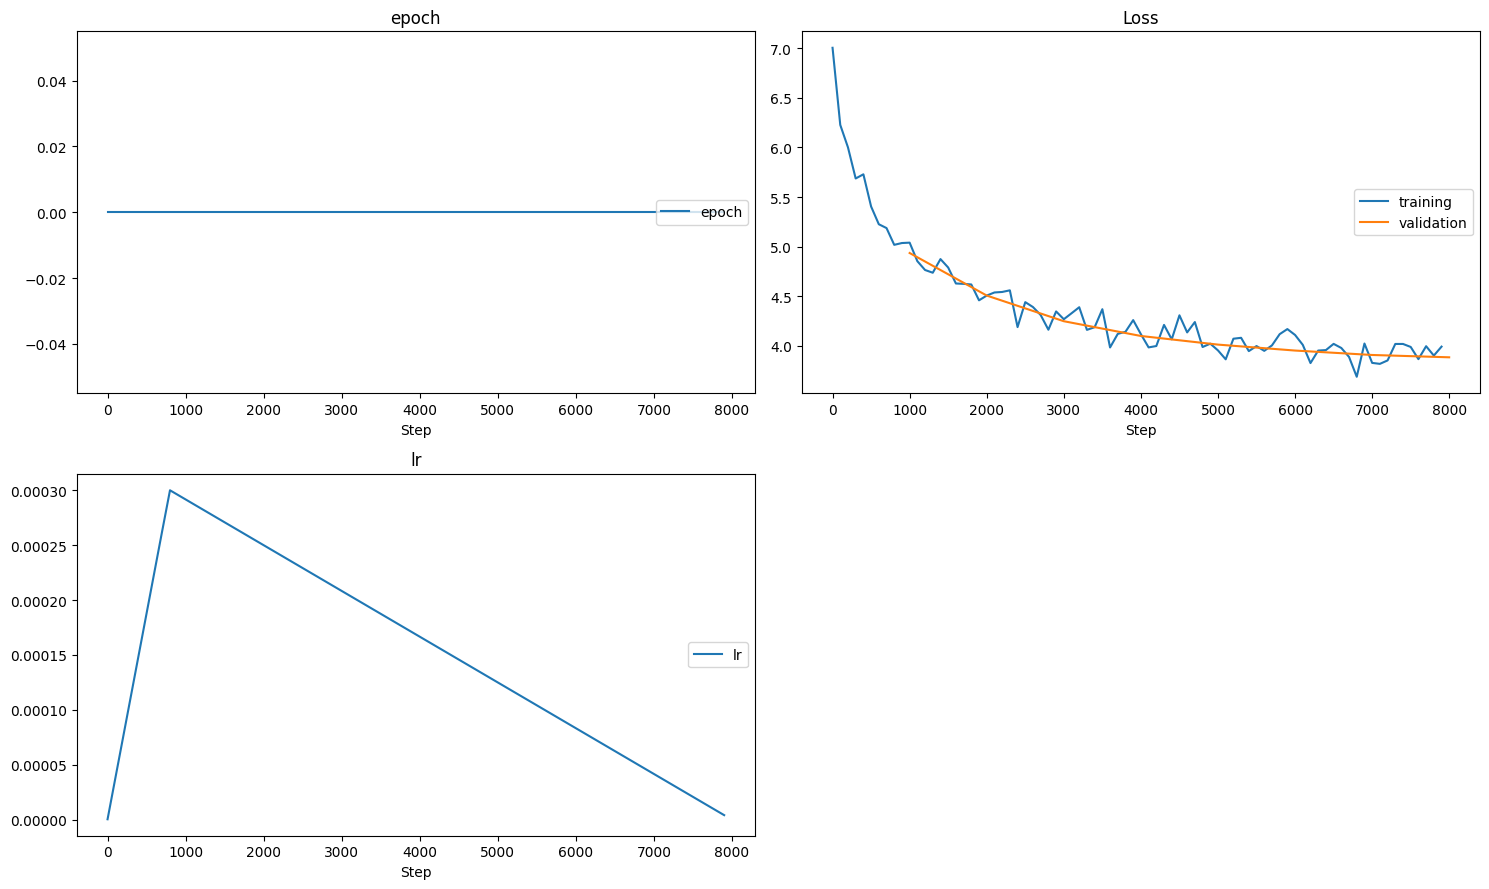

epoch
	epoch            	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    3.688, max:    7.005, cur:    3.992)
	validation       	 (min:    3.885, max:    4.936, cur:    3.885)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)


In [ ]:
# Обучение goes brrrr!

trainer.run(model, train_dataloader, test_dataloader)

In [ ]:
text = "Штирлиц пришел домой"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=trainer.device)[None, :]
print(input_ids)
model_output = model.generate(
    input_ids, max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, temperature=1.6, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

In [ ]:
# Загружаем модель на хаб

model.push_to_hub(REPO_NAME)

Поиграйтесь с гиперпараметрами, попробуйте обучить `mini` и `small` версии.
Постарайтесь добиться как можно более высокого качества как в терминах лосса, так и при визуальной оценке генерации.

### Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Реализовать Rotary Positional Embedding **[4 балла]**
- Реализовать Multi-Head Latent Attention **[2 балл]**
- Оформить репозиторий на 🤗: карточка модели с описанием задания, репортом качества и примерами генерации **[2 балл]**

# Специальный раздел для проверяющего

In [ ]:
device = torch.device("cuda")

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)
check_model = TransformerForCausalLM.from_pretrained(REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

In [ ]:
text = "Штирлиц пришел домой"
input_ids = torch.tensor(tokenizer.encode(text), device=device)

model_output = check_model.generate(
    input_ids[None, :], max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, temperature=2.0, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())